#### 기본 세팅

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size']=15

import warnings
warnings.filterwarnings(action='ignore')

#### 데이터 불러오기

##### 기존 데이터 이용하기

In [ ]:
train = pd.read_csv('/content/train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/test.csv', encoding = 'utf-8')
submission = pd.read_csv('/content/sample_submission.csv', encoding = 'utf-8')

In [ ]:
train.head(2)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


In [ ]:
print(train.shape)
print(test.shape)

(1205, 12)
(50, 10)


In [ ]:
train.columns = ['date', 'dow', 'total', 'vacation', 'business trip', 'overtime', 'athome', 'menu1', 'menu2', 'menu3', 'menu2_people', 'menu3_people']
test.columns = ['date', 'dow', 'total', 'vacation', 'business trip', 'overtime', 'athome', 'menu1', 'menu2', 'menu3']

In [ ]:
train.head(2)

,date,dow,total,vacation,business trip,overtime,athome,menu1,menu2,menu3,menu2_people,menu3_people
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


In [ ]:
train['datetime'] = pd.to_datetime(train['date'])
test['datetime'] = pd.to_datetime(test['date'])

##### new 외부 데이터

###### 날씨

In [ ]:
import requests
from urllib import parse
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

def weather(year: int, station_id: str = "192") -> pd.DataFrame:
    url = "http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList"
    api_key_utf8 = "yUrdX6lY0%2FPUOTlQXTlHHK6eP5vKAeXoZGftInPzC6w0%2BMjq%2B918EkATeobwFBBjfvq2mSpkL06T08hH3ei%2FQA%3D%3D"
    api_key = parse.unquote(api_key_utf8)

    params = {
        "serviceKey": api_key,
        "dataType": "XML",
        "dataCd": "ASOS",
        "dateCd": "DAY",
        "startDt": f"{year}0101",
        "endDt": f"{year}1231",
        "stnIds": station_id,
        "numOfRows": "365",
        "pageNo": "1",
    }

    response = requests.get(url, params=params)

    if response.status_code != 200:
        print("API request failed:", response.status_code)
        return pd.DataFrame()

    soup = BeautifulSoup(response.content, "xml")
    items = soup.find_all("item")

    if not items:
        print("No weather data found.")
        print(response.text)
        return pd.DataFrame()

    data = []
    for item in items:
        try:
            def safe_float(tag):
                try:
                    val = tag.text.strip()
                    return float(val) if val else None
                except:
                    return None

            date = datetime.strptime(item.find("tm").text, "%Y-%m-%d")
            min_temp = safe_float(item.find("minTa"))
            max_temp = safe_float(item.find("maxTa"))
            rainfall = safe_float(item.find("sumRn"))

            data.append({
                "date": date,
                "min_temp": min_temp,
                "max_temp": max_temp,
                "rainfall": 0.0 if rainfall is None else rainfall,
            })
        except Exception as e:
            print("Error parsing item:", e)
            continue

    df = pd.DataFrame(data)

    df["min_temp"].fillna(df["min_temp"].mean(), inplace=True)
    df["max_temp"].fillna(df["max_temp"].mean(), inplace=True)

    return df

years = range(2016, 2022)
weather_df = pd.concat([weather(year) for year in years], ignore_index=True)
weather_df.drop_duplicates(subset="date", inplace=True)

weather_df.rename(columns={"date": "datetime"}, inplace=True)

weather_df["datetime"] = pd.to_datetime(weather_df["datetime"])
train["datetime"] = pd.to_datetime(train["datetime"])
test["datetime"] = pd.to_datetime(test["datetime"])

train = pd.merge(train, weather_df, on="datetime", how="left")
test = pd.merge(test, weather_df, on="datetime", how="left")



###### 공휴일

In [ ]:
import requests
from urllib import parse
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime


def getHoliday(year: int) -> pd.DataFrame:
    url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo"
    api_key_utf8 = "yUrdX6lY0%2FPUOTlQXTlHHK6eP5vKAeXoZGftInPzC6w0%2BMjq%2B918EkATeobwFBBjfvq2mSpkL06T08hH3ei%2FQA%3D%3D"
    api_key_decode = parse.unquote(api_key_utf8)

    params = {
        "ServiceKey": api_key_decode,
        "solYear": year,
        "numOfRows": 100
    }

    response = requests.get(url, params=params)
    xml = BeautifulSoup(response.text, "lxml")
    items = xml.find('items')
    item_list = []
    for item in items.find_all("item"):
        item_dict = {
            "name": item.find("datename").text.strip(),
            "date": datetime.strptime(item.find("locdate").text.strip(), '%Y%m%d')
        }
        item_list.append(item_dict)

    return pd.DataFrame(item_list)

years = range(2016, 2022)
holiday_df = pd.concat([getHoliday(year) for year in years], ignore_index=True)

holiday_df.drop_duplicates(subset="date", inplace=True)

holiday_dates = holiday_df["date"]

train["is_holiday"] = train["datetime"].isin(holiday_dates).astype(int)
test["is_holiday"] = test["datetime"].isin(holiday_dates).astype(int)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1205 non-null   object        
 1   dow            1205 non-null   object        
 2   total          1205 non-null   int64         
 3   vacation       1205 non-null   int64         
 4   business trip  1205 non-null   int64         
 5   overtime       1205 non-null   int64         
 6   athome         1205 non-null   float64       
 7   menu1          1205 non-null   object        
 8   menu2          1205 non-null   object        
 9   menu3          1205 non-null   object        
 10  menu2_people   1205 non-null   float64       
 11  menu3_people   1205 non-null   float64       
 12  datetime       1205 non-null   datetime64[ns]
 13  min_temp       1205 non-null   float64       
 14  max_temp       1205 non-null   float64       
 15  rainfall       1205 n

#### 데이터 전처리하기

##### 날짜 및 요일 전처리

In [ ]:
# 날짜 및 요일 수정하기
train[['year', 'month', 'day']] = train['date'].str.extract('(\d{4})-(\d{2})-(\d{2})').astype('int64')
train.drop('date', axis=1, inplace=True)
test[['year', 'month', 'day']] = test['date'].str.extract('(\d{4})-(\d{2})-(\d{2})').astype('int64')
test.drop('date', axis=1, inplace=True)

day_mapping = {'월': 1, '화': 2, '수': 3, '목': 4, '금': 5, '토': 6, '일': 7}
train['dow'] = train['dow'].map(day_mapping).astype('int64')
test['dow'] = test['dow'].map(day_mapping).astype('int64')

train.head(2)

,dow,total,vacation,business trip,overtime,athome,menu1,menu2,menu3,menu2_people,menu3_people,datetime,min_temp,max_temp,rainfall,is_holiday,year,month,day
0,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016-02-01,-4.1,5.0,0.0,0,2016,2,1
1,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2016-02-02,-9.1,6.2,0.0,0,2016,2,2


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dow            1205 non-null   int64         
 1   total          1205 non-null   int64         
 2   vacation       1205 non-null   int64         
 3   business trip  1205 non-null   int64         
 4   overtime       1205 non-null   int64         
 5   athome         1205 non-null   float64       
 6   menu1          1205 non-null   object        
 7   menu2          1205 non-null   object        
 8   menu3          1205 non-null   object        
 9   menu2_people   1205 non-null   float64       
 10  menu3_people   1205 non-null   float64       
 11  datetime       1205 non-null   datetime64[ns]
 12  min_temp       1205 non-null   float64       
 13  max_temp       1205 non-null   float64       
 14  rainfall       1205 non-null   float64       
 15  is_holiday     1205 n

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dow            50 non-null     int64         
 1   total          50 non-null     int64         
 2   vacation       50 non-null     int64         
 3   business trip  50 non-null     int64         
 4   overtime       50 non-null     int64         
 5   athome         50 non-null     float64       
 6   menu1          50 non-null     object        
 7   menu2          50 non-null     object        
 8   menu3          50 non-null     object        
 9   datetime       50 non-null     datetime64[ns]
 10  min_temp       50 non-null     float64       
 11  max_temp       50 non-null     float64       
 12  rainfall       50 non-null     float64       
 13  is_holiday     50 non-null     int64         
 14  year           50 non-null     int64         
 15  month          50 non-nul

In [ ]:
train['date'] = pd.to_datetime(train[['year', 'month', 'day']])
train = train.sort_values('date').reset_index(drop=True)

##### 데이터 시각화

###### 날짜별 식수

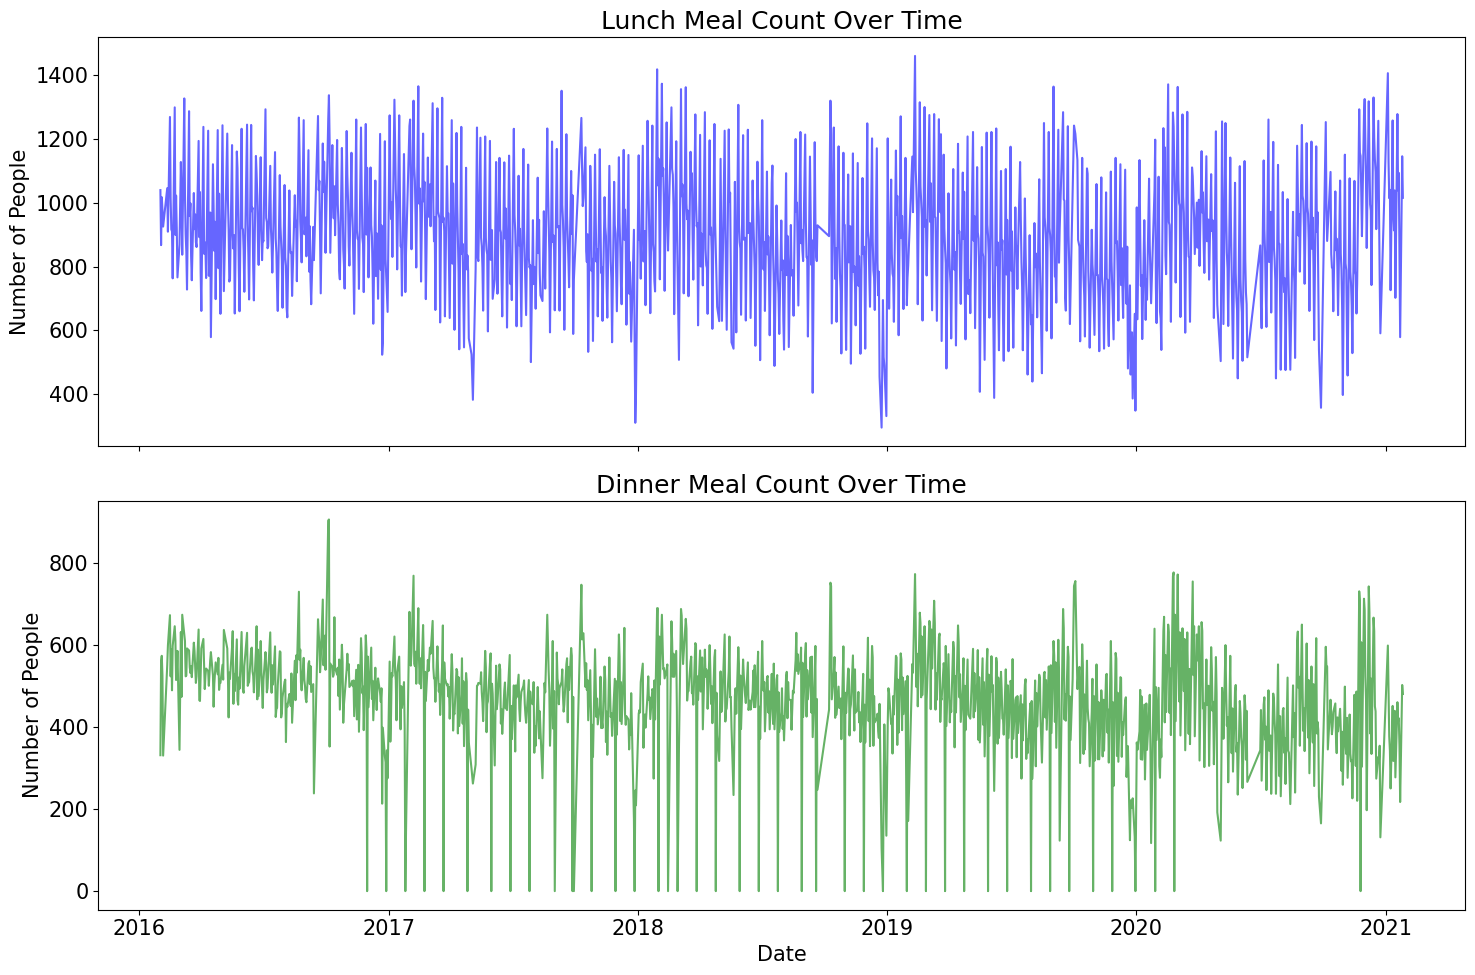

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Lunch trend
axes[0].plot(train['datetime'], train['menu2_people'], color='blue', alpha=0.6)
axes[0].set_title('Lunch Meal Count Over Time')
axes[0].set_ylabel('Number of People')

# Dinner trend
axes[1].plot(train['datetime'], train['menu3_people'], color='green', alpha=0.6)
axes[1].set_title('Dinner Meal Count Over Time')
axes[1].set_ylabel('Number of People')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

###### 요일별 식수

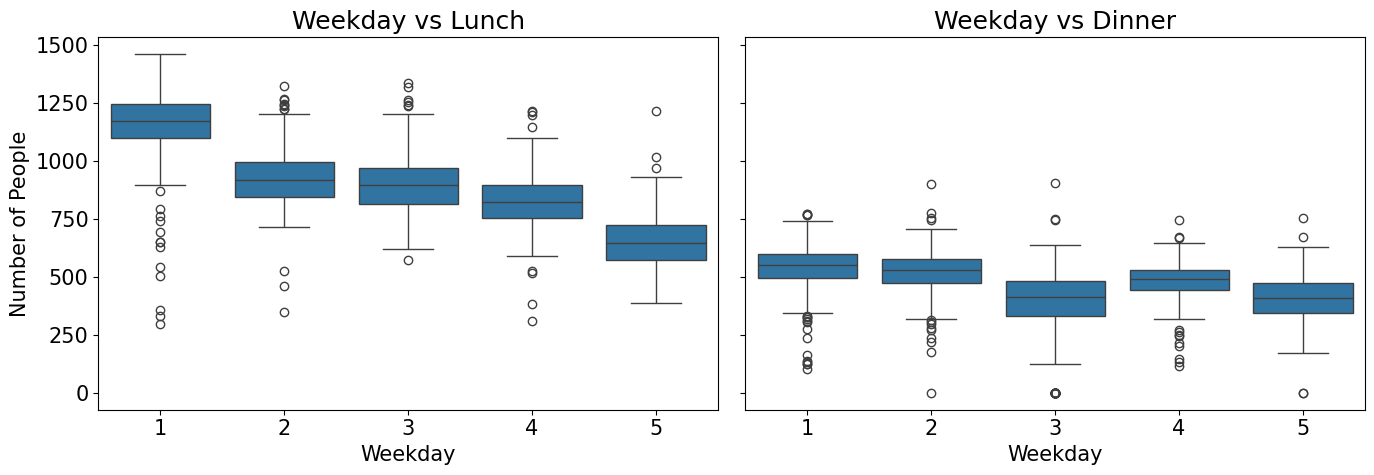

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.boxplot(data=train, x='dow', y='menu2_people', ax=axes[0])
axes[0].set_title('Weekday vs Lunch')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Number of People')

sns.boxplot(data=train, x='dow', y='menu3_people', ax=axes[1])
axes[1].set_title('Weekday vs Dinner')
axes[1].set_xlabel('Weekday')

plt.tight_layout()
plt.show()

###### 공휴일 비공휴일 비교

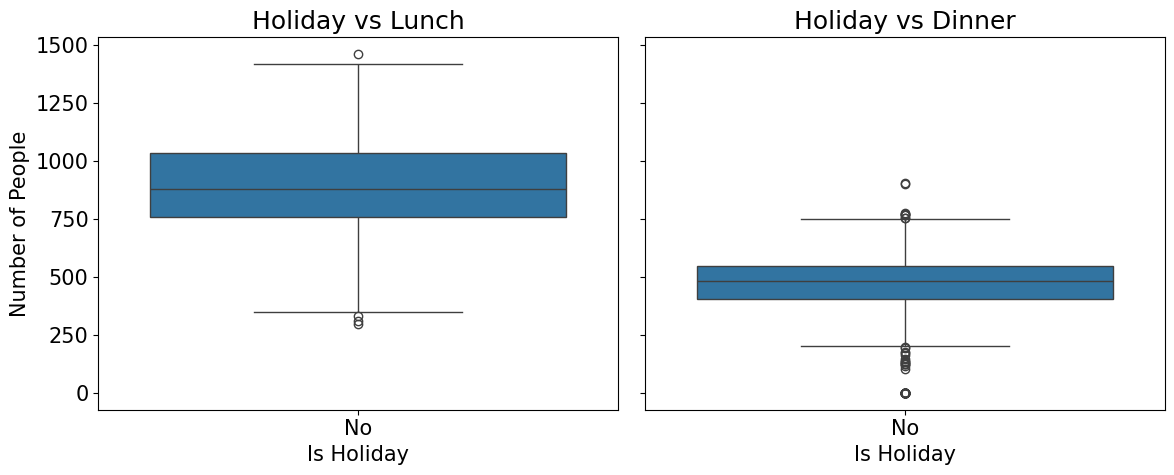

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.boxplot(data=train, x='is_holiday', y='menu2_people', ax=axes[0])
axes[0].set_title('Holiday vs Lunch')
axes[0].set_xlabel('Is Holiday')
axes[0].set_ylabel('Number of People')
axes[0].set_xticklabels(['No', 'Yes'])

sns.boxplot(data=train, x='is_holiday', y='menu3_people', ax=axes[1])
axes[1].set_title('Holiday vs Dinner')
axes[1].set_xlabel('Is Holiday')
axes[1].set_xticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

###### 월별

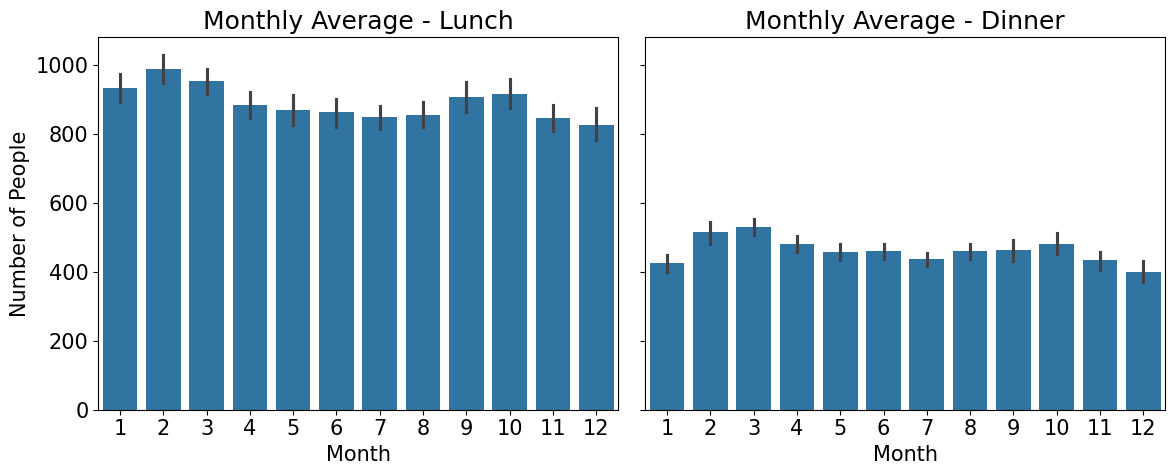

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.barplot(data=train, x='month', y='menu2_people', ax=axes[0])
axes[0].set_title('Monthly Average - Lunch')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of People')

sns.barplot(data=train, x='month', y='menu3_people', ax=axes[1])
axes[1].set_title('Monthly Average - Dinner')
axes[1].set_xlabel('Month')

plt.tight_layout()
plt.show()

###### 인사 관련 변수

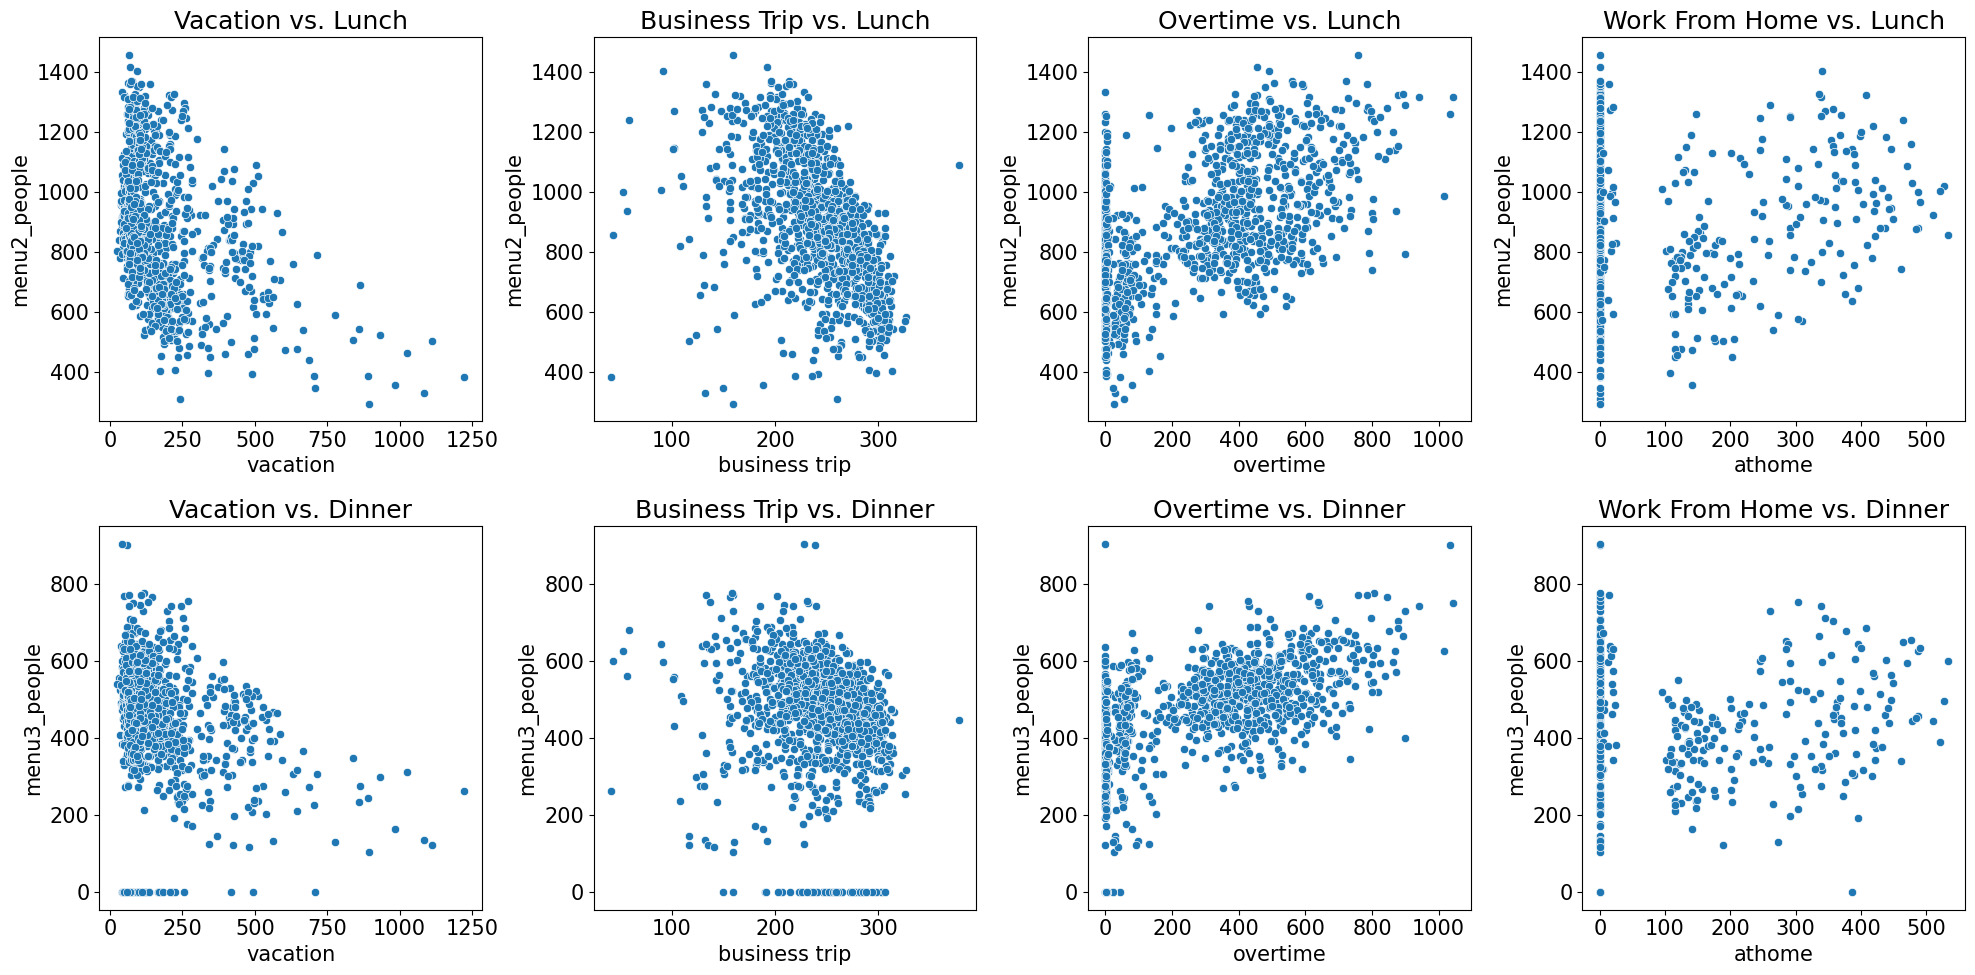

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

sns.scatterplot(data=train, x='vacation', y='menu2_people', ax=axes[0, 0])
axes[0, 0].set_title('Vacation vs. Lunch')

sns.scatterplot(data=train, x='business trip', y='menu2_people', ax=axes[0, 1])
axes[0, 1].set_title('Business Trip vs. Lunch')

sns.scatterplot(data=train, x='overtime', y='menu2_people', ax=axes[0, 2])
axes[0, 2].set_title('Overtime vs. Lunch')

sns.scatterplot(data=train, x='athome', y='menu2_people', ax=axes[0, 3])
axes[0, 3].set_title('Work From Home vs. Lunch')

sns.scatterplot(data=train, x='vacation', y='menu3_people', ax=axes[1, 0])
axes[1, 0].set_title('Vacation vs. Dinner')

sns.scatterplot(data=train, x='business trip', y='menu3_people', ax=axes[1, 1])
axes[1, 1].set_title('Business Trip vs. Dinner')

sns.scatterplot(data=train, x='overtime', y='menu3_people', ax=axes[1, 2])
axes[1, 2].set_title('Overtime vs. Dinner')

sns.scatterplot(data=train, x='athome', y='menu3_people', ax=axes[1, 3])
axes[1, 3].set_title('Work From Home vs. Dinner')

plt.tight_layout()
plt.show()

###### 최대, 최소 일 비교

In [ ]:
print("Top 10 Lunch Days")
print(train.sort_values(by='menu2_people', ascending=False)[['date', 'menu2_people', 'menu2']].head(10))

print("\nTop 10 Dinner Days")
print(train.sort_values(by='menu3_people', ascending=False)[['date', 'menu3_people', 'menu3']].head(10))

print("\n Bottom 10 Lunch Days")
print(train.sort_values(by='menu2_people', ascending=True)[['date', 'menu2_people', 'menu2']].head(10))

print("\n Bottom 10 Dinner Days")
print(train.sort_values(by='menu3_people', ascending=True)[['date', 'menu3_people', 'menu3']].head(10))


Top 10 Lunch Days
           date  menu2_people  \
735  2019-02-11        1459.0   
490  2018-01-29        1417.0   
1188 2021-01-04        1405.0   
495  2018-02-05        1372.0   
986  2020-02-17        1370.0   
255  2017-02-13        1364.0   
875  2019-09-02        1363.0   
996  2020-03-02        1362.0   
517  2018-03-12        1361.0   
512  2018-03-05        1355.0   

                                                  menu2  
735   쌀밥/잡곡밥 (쌀:국내산) 어묵국  소불고기 (소고기:호주산) 계란말이  실곤약초무...  
490   쌀밥/잡곡밥 (쌀:국내산) 봄동된장국  가래떡돼지갈비찜  콩나물겨자채  참나물무침 ...  
1188  쌀밥/흑미밥/찰현미밥 소고기떡국 봉추찜닭 오미산적/동태전 콩나물잡채 포기김치/식혜 ...  
495   쌀밥/잡곡밥 (쌀:국내산) 순두부찌개  돈육볶음  홍어채무침  시래기조림  포기김치...  
986   쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 쇠고기샤브국 (쇠고기:호주산) 유자청제육볶음 ...  
255   쌀밥/잡곡밥 (쌀:국내산) 쇠고기미역국  제육볶음  두부구이*양념장  도라지오이생채...  
875   쌀밥/잡곡밥 (쌀:국내산) 들깨시락국  돈육김치볶음  궁중떡볶음  쫑상추무침  포기...  
996   쌀밥/잡곡밥 (쌀,현미,흑미:국내산) 두부김치국  소고기버섯볶음  모듬묵*장  치커...  
517   쌀밥/잡곡밥 (쌀:국내산) 배추된장국  버섯불고기  시금치프리타타  부추생채  포기...  
512   쌀밥/잡곡밥 (쌀:국내산) 해물순두부찌개  소고기장조림  

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dow            1205 non-null   int64         
 1   total          1205 non-null   int64         
 2   vacation       1205 non-null   int64         
 3   business trip  1205 non-null   int64         
 4   overtime       1205 non-null   int64         
 5   athome         1205 non-null   float64       
 6   menu1          1205 non-null   object        
 7   menu2          1205 non-null   object        
 8   menu3          1205 non-null   object        
 9   menu2_people   1205 non-null   float64       
 10  menu3_people   1205 non-null   float64       
 11  datetime       1205 non-null   datetime64[ns]
 12  min_temp       1205 non-null   float64       
 13  max_temp       1205 non-null   float64       
 14  rainfall       1205 non-null   float64       
 15  is_holiday     1205 n

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dow            50 non-null     int64         
 1   total          50 non-null     int64         
 2   vacation       50 non-null     int64         
 3   business trip  50 non-null     int64         
 4   overtime       50 non-null     int64         
 5   athome         50 non-null     float64       
 6   menu1          50 non-null     object        
 7   menu2          50 non-null     object        
 8   menu3          50 non-null     object        
 9   datetime       50 non-null     datetime64[ns]
 10  min_temp       50 non-null     float64       
 11  max_temp       50 non-null     float64       
 12  rainfall       50 non-null     float64       
 13  is_holiday     50 non-null     int64         
 14  year           50 non-null     int64         
 15  month          50 non-nul

##### 메뉴명 전처리!!!!

In [ ]:
train.drop(['menu1'], inplace=True, axis=1)
test.drop(['menu1'], inplace=True, axis=1)

###### 점심 train

In [ ]:
# 모든 점심 메뉴 모으기
import re
lunch = []

for i in range(len(train)):
  tmp = train.iloc[i, 6].split(' ')
  tmp = ' '.join(tmp).split()

  for j in tmp:
    if '(' in j:
      tmp.remove(j)

  lunch.append(tmp)

lunch[0:3]

[['쌀밥/잡곡밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이'],
 ['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치']]

In [ ]:
# menu개수 세기
menu_item_counts = []

for menu in lunch:
    menu_item_counts.append(len(menu))

menu_item_counts

[7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,


In [ ]:
# 종류별 분류
lunch_bab = []
lunch_gook = []
lunch_banchan1=[]
lunch_banchan2=[]
lunch_banchan3=[]
lunch_side = []

for i in range(len(train)):
  lunch_bab.append(lunch[i][0])
  lunch_gook.append(lunch[i][1])
  lunch_banchan1.append(lunch[i][2])
  lunch_banchan2.append(lunch[i][3])
  lunch_banchan3.append(lunch[i][4])
  lunch_side.append(menu_item_counts[i]-6)
  if '쌀밥' in lunch_bab[i]:
        lunch_bab[i] = '밥'

In [ ]:
print(len(lunch_bab))
print(len(lunch_gook))
print(len(lunch_banchan1))
print(len(lunch_banchan2))
print(len(lunch_banchan3))
print(len(lunch_side))

1205
1205
1205
1205
1205
1205


In [ ]:
train['lunch_bab'] = lunch_bab
train['lunch_gook'] = lunch_gook
train['lunch_banchan1'] = lunch_banchan1
train['lunch_banchan2'] = lunch_banchan2
train['lunch_banchan3'] = lunch_banchan3
train['lunch_side'] = lunch_side

train.drop('menu2', axis=1, inplace=True)

In [ ]:
train.head(2)

,dow,total,vacation,business trip,overtime,athome,menu3,menu2_people,menu3_people,datetime,...,year,month,day,date,lunch_bab,lunch_gook,lunch_banchan1,lunch_banchan2,lunch_banchan3,lunch_side
0,1,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016-02-01,...,2016,2,1,2016-02-01,밥,오징어찌개,쇠불고기,계란찜,청포묵무침,1
1,2,2601,50,173,319,0.0,"콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2016-02-02,...,2016,2,2,2016-02-02,밥,김치찌개,가자미튀김,모둠소세지구이,마늘쫑무침,1


In [ ]:
train['lunch_bab'].value_counts()

,count
lunch_bab,
밥,1003
콩나물밥,23
카레덮밥,18
나물비빔밥,15
곤드레밥*강된장,12
단호박영양밥,10
곤드레밥,8
비빔밥,8
김치제육덮밥,8


In [ ]:
train['lunch_gook'].value_counts()

,count
lunch_gook,
맑은국,46
콩나물국,44
된장찌개,37
어묵국,31
가쯔오장국,28
...,...
황태채국,1
어묵매운탕,1
불낙찌개,1


In [ ]:
train['lunch_banchan1'].value_counts()

,count
lunch_banchan1,
오징어볶음,32
닭갈비,30
버섯불고기,29
훈제오리구이,27
돈육굴소스볶음,25
...,...
고등어구이*와사비장,1
삼겹살김치찜,1
수제함박스테이크,1


In [ ]:
train['lunch_banchan2'].value_counts()

,count
lunch_banchan2,
계란말이,27
새송이버섯전,24
계란찜,24
메추리알조림,18
우엉잡채,18
...,...
어묵고추장볶음,1
얼갈이나물,1
적어양념장구이,1


In [ ]:
train['lunch_banchan3'].value_counts()

,count
lunch_banchan3,
오이무침,34
콩나물무침,28
숙주나물,24
무생채,22
시금치나물,19
...,...
단배추나물/치킨무,1
시래기지짐,1
모듬묵*양념장,1


###### 점심 test

In [ ]:
# 모든 점심 메뉴 모으기
import re
luncht = []

for i in range(len(test)):
  tmp = test.iloc[i,6].split(' ')
  tmp = ' '.join(tmp).split()

  for j in tmp:
    if '(' in j:
      tmp.remove(j)

  luncht.append(tmp)

luncht[0:3]

[['쌀밥/흑미밥/찰현미밥', '대구지리', '매운돈갈비찜', '오꼬노미계란말이', '상추무침', '포기김치', '양상추샐러드*딸기D'],
 ['쌀밥/보리밥/찰현미밥', '우렁된장찌개', '오리주물럭', '청양부추전', '수제삼색무쌈', '겉절이김치', '양상추샐러드*오미자D'],
 ['쌀밥/흑미밥/찰현미밥',
  '팽이장국',
  '수제돈까스*소스',
  '가자미조림',
  '동초나물무침',
  '포기김치',
  '양상추샐러드*파인요거트D']]

In [ ]:
# menu개수 세기
menu_item_countst = []

for menu in luncht:
    menu_item_countst.append(len(menu))

menu_item_countst

[7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 7,
 7,
 7,
 7,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 7]

In [ ]:
# 종류별 분류
luncht_bab = []
luncht_gook = []
luncht_banchan1=[]
luncht_banchan2=[]
luncht_banchan3=[]
luncht_side = []

for i in range(len(test)):
  luncht_bab.append(luncht[i][0])
  luncht_gook.append(luncht[i][1])
  luncht_banchan1.append(luncht[i][2])
  luncht_banchan2.append(luncht[i][3])
  luncht_banchan3.append(luncht[i][4])
  luncht_side.append(menu_item_countst[i]-6)
  if '쌀밥' in luncht_bab[i]:
        luncht_bab[i] = '밥'

In [ ]:
print(len(luncht_bab))
print(len(luncht_gook))
print(len(luncht_banchan1))
print(len(luncht_banchan2))
print(len(luncht_banchan3))
print(len(luncht_side))

50
50
50
50
50
50


In [ ]:
test['lunch_bab'] = luncht_bab
test['lunch_gook'] = luncht_gook
test['lunch_banchan1'] = luncht_banchan1
test['lunch_banchan2'] = luncht_banchan2
test['lunch_banchan3'] = luncht_banchan3
test['lunch_side'] = luncht_side

test.drop('menu2', axis=1, inplace=True)

In [ ]:
test.head(2)

,dow,total,vacation,business trip,overtime,athome,menu3,datetime,min_temp,max_temp,...,is_holiday,year,month,day,lunch_bab,lunch_gook,lunch_banchan1,lunch_banchan2,lunch_banchan3,lunch_side
0,3,2983,88,182,5,358.0,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2021-01-27,-1.2,11.4,...,0,2021,1,27,밥,대구지리,매운돈갈비찜,오꼬노미계란말이,상추무침,1
1,4,2983,104,212,409,348.0,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,2021-01-28,-3.0,10.7,...,0,2021,1,28,밥,우렁된장찌개,오리주물럭,청양부추전,수제삼색무쌈,1


###### 저녁 train

In [ ]:
# 모든 저녁 메뉴 모으기
import re
dinner = []

for i in range(len(train)):
  tmp = train.iloc[i, 6].split(' ')
  tmp = ' '.join(tmp).split()

  for j in tmp:
    if '(' in j:
      tmp.remove(j)

  dinner.append(tmp)

dinner[0:3]

[['쌀밥/잡곡밥', '육개장', '자반고등어구이', '두부조림', '건파래무침', '포기김치'],
 ['콩나물밥*양념장', '어묵국', '유산슬', '아삭고추무침', '바나나', '포기김치'],
 ['쌀밥/잡곡밥', '청국장찌개', '황태양념구이', '고기전', '새송이버섯볶음', '포기김치']]

In [ ]:
# menu개수 세기
menu_item_counts_d = []

for menu in dinner:
    menu_item_counts_d.append(len(menu))

    if(len(menu)<=5):
      print(menu)

    if(len(menu)>7):
      print('아아아아아아아아아아아아아아아아')
      print(menu)

menu_item_counts_d

['*']
['*']
['*']
['*']
['쌀밥/잡곡밥', '미역국', '궁중떡찜', '양배추쌈', '포기김치']
['*']
['*']
['자기계발의날']
['*자기계발의날*']
['가정의날']
['*']
['*']
['*']
['*']
['*']
['*']
['*']
['김밥', '나가사끼짬뽕', '단무지', '요플레', '포기김치']
['*']
[]
['쌀밥/잡곡밥', '콩나물김치국', '계란말이', '깻순나물', '알타리김치']
[]
['*']
['*']
[]
['*']
[]
['자기계발의날']
['*']
['자기계발의날']
['자기개발의날']
['*', '자기계발의날', '*']
['*', '자기개발의날', '*']
['*', '자기계발의날', '*']
['김밥', '잔치국수', '야채튀김', '바나나', '포기김치']
['*', '자기개발의날', '*']
['*', '자기개발의날', '*']
['자기계발의날']
['*']
['*']
['*']
['*']
['*']
['자기개발의날']
['자기개발의날']
아아아아아아아아아아아아아아아아
['작은밥', '백종원의', '고추짜장', '맑은국', '칠리베이비크랩', '시금치흑임자샐러드', '단무지', '포기김치']
['흑미밥', '참치파개장', '오징어불고기', '생깻잎지', '포기김치']
['폭탄주먹밥', '꼬치어묵국', '매운떡볶이', '순대찜*소금', '포기김치']
['흑미밥', '열무된장국', '우불고기', '치커리무침', '포기김치']
['흑미밥', '미역국', '오징어채소볶음', '쪽파김무침', '포기김치']
['흑미밥', '소고기무국', '스팸계란말이', '풋고추양파무침', '포기김치']
['흑미밥', '홍합탕', '건도토리묵파프리카볶음', '연근깨소스무침', '포기김치']
['흑미밥', '된장찌개', '고구마치즈구이', '오이생채', '포기김치']
['흑미밥', '콩나물국', '돈육김치볶음', '꼬시래기무침', '포기김치']
['미역국', '대패삼겹숙주볶음', '연두부계란찜', '상추무침', 

[6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 1,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 1,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 1,
 6,
 6,
 6,
 6,
 6,


In [ ]:
index = next(
    (i for i, sublist in enumerate(dinner) if any("백종원의" in element for element in sublist)),
    -1
)
print(index)
print(dinner[index])

1027
['작은밥', '백종원의', '고추짜장', '맑은국', '칠리베이비크랩', '시금치흑임자샐러드', '단무지', '포기김치']


In [ ]:
dinner[index] = ['작은밥', '맑은국', '고추짜장', '칠리베이비크랩', '시금치흑임자샐러드', '단무지', '포기김치']

In [ ]:
# 종류별 분류
dinner_bab = []
dinner_gook = []
dinner_banchan1=[]
dinner_banchan2=[]
dinner_banchan3=[]
dinner_side = []

for idx, i in enumerate(dinner):
  if((len(i)==0) or ('*' in i) or ('가정의날' in i) or ('가정의달' in i) or ('자기계발의날' in i) or ('*자기계발의날*' in i) or ('자기개발의날' in i) or ('＜자기' in i)):
    dinner_bab.append('None')
    dinner_gook.append('None')
    dinner_banchan1.append('None')
    dinner_banchan2.append('None')
    dinner_banchan3.append('None')
    dinner_side.append('None')
  else:
    dinner_bab.append(i[0])
    dinner_gook.append(i[1])
    dinner_banchan1.append(i[2])
    dinner_banchan2.append(i[3])
    if(menu_item_counts_d[idx]<=5):
      dinner_banchan3.append('None')
    else:
      dinner_banchan3.append(i[4])

    if menu_item_counts_d[idx] == 7:
      dinner_side.append('1')
    else:
      dinner_side.append('0')

    if '쌀밥' in dinner_bab[idx]:
          dinner_bab[idx] = '밥'

In [ ]:
print(len(dinner_bab))
print(len(dinner_gook))
print(len(dinner_banchan1))
print(len(dinner_banchan2))
print(len(dinner_banchan3))
print(len(dinner_side))

1205
1205
1205
1205
1205
1205


In [ ]:
train['dinner_bab'] = dinner_bab
train['dinner_gook'] = dinner_gook
train['dinner_banchan1'] = dinner_banchan1
train['dinner_banchan2'] = dinner_banchan2
train['dinner_banchan3'] = dinner_banchan3
train['dinner_side'] = dinner_side

train.drop('menu3', axis=1, inplace=True)

In [ ]:
train.head(2)

,dow,total,vacation,business trip,overtime,athome,menu2_people,menu3_people,datetime,min_temp,...,lunch_banchan1,lunch_banchan2,lunch_banchan3,lunch_side,dinner_bab,dinner_gook,dinner_banchan1,dinner_banchan2,dinner_banchan3,dinner_side
0,1,2601,50,150,238,0.0,1039.0,331.0,2016-02-01,-4.1,...,쇠불고기,계란찜,청포묵무침,1,밥,육개장,자반고등어구이,두부조림,건파래무침,0
1,2,2601,50,173,319,0.0,867.0,560.0,2016-02-02,-9.1,...,가자미튀김,모둠소세지구이,마늘쫑무침,1,콩나물밥*양념장,어묵국,유산슬,아삭고추무침,바나나,0


In [ ]:
train['dinner_bab'].value_counts()

,count
dinner_bab,
밥,664
흑미밥,92
None,42
유부초밥,25
김밥,25
...,...
고추잡채덮밥,1
팽이장국,1
미니쌀국수,1


In [ ]:
train['dinner_gook'].value_counts()

,count
dinner_gook,
None,42
잔치국수,37
맑은국,34
된장찌개,30
육개장,29
...,...
맑은버섯국,1
순두부백탕,1
북어짬뽕국,1


In [ ]:
train['dinner_banchan1'].value_counts()

,count
dinner_banchan1,
None,42
닭갈비,16
떡볶이,16
돈육강정,15
돈육굴소스볶음,14
...,...
브로콜리깨소스무침,1
삼치양념구이,1
수제맛쵸킹탕수육,1


In [ ]:
train['dinner_banchan2'].value_counts()

,count
dinner_banchan2,
None,42
꽃맛살샐러드,30
멕시칸샐러드,20
계란찜,16
과일샐러드,16
...,...
새우또띠아/음료,1
호박부추전,1
꽃빵튀김*연유,1


In [ ]:
train['dinner_banchan3'].value_counts()

,count
dinner_banchan3,
None,72
단무지,23
무피클,22
단무지무침,21
부추생채,19
...,...
무비트생채/음료,1
세발나물/과일,1
무비트생채,1


###### 저녁 test

In [ ]:
# 모든 저녁 메뉴 모으기
import re
dinnert = []

for i in range(len(test)):
  tmp = test.iloc[i, 6].split(' ')
  tmp = ' '.join(tmp).split()

  for j in tmp:
    if '(' in j:
      tmp.remove(j)

  dinnert.append(tmp)

dinnert[0:3]

[['흑미밥', '얼큰순두부찌개', '쇠고기우엉볶음', '버섯햄볶음', '포기김치'],
 ['충무김밥', '우동국물', '오징어무침', '꽃맛살샐러드', '얼갈이쌈장무침', '석박지'],
 ['흑미밥', '물만둣국', '카레찜닭', '숯불양념꼬지어묵', '꼬시래기무침', '포기김치']]

In [ ]:
# menu개수 세기
menu_item_counts_dt = []

for menu in dinnert:
    menu_item_counts_dt.append(len(menu))

    if(len(menu)<=5):
      print(menu)

    if(len(menu)>7):
      print('아아아아아아아아아아아아아아아아')
      print(menu)

menu_item_counts_dt

['흑미밥', '얼큰순두부찌개', '쇠고기우엉볶음', '버섯햄볶음', '포기김치']
['흑미밥', '매운족발볶음', '크래미오이보트샐러드', '청경채나물', '겉절이김치']
['샐러드김밥', '미소시루', '라볶이', '단무지채무침', '포기김치']
['쇠고기규동덮밥', '가쓰오장국', '연근땅콩조림', '청경채겉절이', '포기김치']


[5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6]

In [ ]:
# 종류별 분류
dinnert_bab = []
dinnert_gook = []
dinnert_banchan1=[]
dinnert_banchan2=[]
dinnert_banchan3=[]
dinnert_side = []

for idx, i in enumerate(dinnert):
  if((len(i)==0) or ('*' in i) or ('가정의날' in i) or ('가정의달' in i) or ('자기계발의날' in i) or ('*자기계발의날*' in i) or ('자기개발의날' in i) or ('＜자기' in i)):
    dinnert_bab.append('None')
    dinnert_gook.append('None')
    dinnert_banchan1.append('None')
    dinnert_banchan2.append('None')
    dinnert_banchan3.append('None')
    dinnert_side.append('None')

  else:
    dinnert_bab.append(i[0])
    dinnert_gook.append(i[1])
    dinnert_banchan1.append(i[2])
    dinnert_banchan2.append(i[3])

    if(menu_item_counts_dt[idx]<=5):
      dinnert_banchan3.append('None')

    else:
      dinnert_banchan3.append(i[4])

    if menu_item_counts_dt[idx] == 7:
      dinnert_side.append('1')
    else:
      dinnert_side.append('0')

    if '쌀밥' in dinnert_bab[idx]:
          dinnert_bab[idx] = '밥'

In [ ]:
print(len(dinnert_bab))
print(len(dinnert_gook))
print(len(dinnert_banchan1))
print(len(dinnert_banchan2))
print(len(dinnert_banchan3))
print(len(dinnert_side))

50
50
50
50
50
50


In [ ]:
test['dinner_bab'] = dinnert_bab
test['dinner_gook'] = dinnert_gook
test['dinner_banchan1'] = dinnert_banchan1
test['dinner_banchan2'] = dinnert_banchan2
test['dinner_banchan3'] = dinnert_banchan3
test['dinner_side'] = dinnert_side

test.drop('menu3', axis=1, inplace=True)

##### encoding

###### train

In [ ]:
#encoding

train['lunch_bab'] = train['lunch_bab'].astype('category')
train['lunch_bab'] = train.lunch_bab.cat.codes

train['lunch_gook'] = train['lunch_gook'].astype('category')
train['lunch_gook'] = train.lunch_gook.cat.codes

train['lunch_banchan1'] = train['lunch_banchan1'].astype('category')
train['lunch_banchan1'] = train.lunch_banchan1.cat.codes

train['lunch_banchan2'] = train['lunch_banchan2'].astype('category')
train['lunch_banchan2'] = train.lunch_banchan2.cat.codes

train['lunch_banchan3'] = train['lunch_banchan3'].astype('category')
train['lunch_banchan3'] = train.lunch_banchan3.cat.codes

train['lunch_side'] = train['lunch_side'].astype('category')
train['lunch_side'] = train.lunch_side.cat.codes

train['dinner_bab'] = train['dinner_bab'].astype('category')
train['dinner_bab'] = train.dinner_bab.cat.codes

train['dinner_gook'] = train['dinner_gook'].astype('category')
train['dinner_gook'] = train.dinner_gook.cat.codes

train['dinner_banchan1'] = train['dinner_banchan1'].astype('category')
train['dinner_banchan1'] = train.dinner_banchan1.cat.codes

train['dinner_banchan2'] = train['dinner_banchan2'].astype('category')
train['dinner_banchan2'] = train.dinner_banchan2.cat.codes

train['dinner_banchan3'] = train['dinner_banchan3'].astype('category')
train['dinner_banchan3'] = train.dinner_banchan3.cat.codes

train['dinner_side'] = train['dinner_side'].astype('category')
train['dinner_side'] = train.dinner_side.cat.codes

In [ ]:
train['present'] = train['total'] - train['vacation']-train['business trip']-train['athome']
train.drop(['date'], inplace = True, axis = 1)

In [ ]:
train.head(2)

,dow,total,vacation,business trip,overtime,athome,menu2_people,menu3_people,datetime,min_temp,...,lunch_banchan2,lunch_banchan3,lunch_side,dinner_bab,dinner_gook,dinner_banchan1,dinner_banchan2,dinner_banchan3,dinner_side,present
0,1,2601,50,150,238,0.0,1039.0,331.0,2016-02-01,-4.1,...,35,377,2,39,222,340,160,17,0,2401.0
1,2,2601,50,173,319,0.0,867.0,560.0,2016-02-02,-9.1,...,189,103,2,106,181,334,334,170,0,2378.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   dow              1205 non-null   int64         
 1   total            1205 non-null   int64         
 2   vacation         1205 non-null   int64         
 3   business trip    1205 non-null   int64         
 4   overtime         1205 non-null   int64         
 5   athome           1205 non-null   float64       
 6   menu2_people     1205 non-null   float64       
 7   menu3_people     1205 non-null   float64       
 8   datetime         1205 non-null   datetime64[ns]
 9   min_temp         1205 non-null   float64       
 10  max_temp         1205 non-null   float64       
 11  rainfall         1205 non-null   float64       
 12  is_holiday       1205 non-null   int64         
 13  year             1205 non-null   int64         
 14  month            1205 non-null   int64  

In [ ]:
train.corr()

,dow,total,vacation,business trip,overtime,athome,menu2_people,menu3_people,datetime,min_temp,...,lunch_banchan2,lunch_banchan3,lunch_side,dinner_bab,dinner_gook,dinner_banchan1,dinner_banchan2,dinner_banchan3,dinner_side,present
dow,1.000000,-0.008577,0.155578,0.532962,-0.554359,-0.026795,-0.731563,-0.312112,-0.010249,-0.009329,...,0.042163,-0.068555,0.013108,-0.017542,0.015916,0.063241,0.020756,-0.003503,0.022245,-0.250092
total,-0.008577,1.000000,0.244666,-0.061688,0.146544,0.452293,-0.115529,-0.173852,0.811900,0.079941,...,0.037608,-0.019752,0.319817,0.245683,-0.033323,-0.010822,-0.019431,-0.085497,0.002376,0.503771
vacation,0.155578,0.244666,1.000000,-0.273318,-0.230789,0.065397,-0.391975,-0.316894,0.168330,0.212695,...,0.031488,-0.006191,0.133623,0.049133,0.058444,-0.019400,-0.032459,-0.016755,-0.011236,-0.552661
business trip,0.532962,-0.061688,-0.273318,1.000000,-0.308757,-0.352643,-0.512680,-0.188164,-0.065052,0.100638,...,-0.016484,-0.047056,-0.162579,-0.137174,-0.033721,0.027132,0.014539,0.000568,0.047786,0.136389
overtime,-0.554359,0.146544,-0.230789,-0.308757,1.000000,0.156792,0.535611,0.571168,0.183705,-0.053149,...,-0.049402,0.066841,0.073464,0.212588,0.049575,0.107368,0.060677,-0.018596,-0.199558,0.309118
athome,-0.026795,0.452293,0.065397,-0.352643,0.156792,1.000000,0.076509,-0.057534,0.576922,-0.031830,...,0.094333,-0.007285,0.593405,0.401352,-0.031037,-0.012436,0.001094,-0.072078,-0.013393,-0.150393
menu2_people,-0.731563,-0.115529,-0.391975,-0.512680,0.535611,0.076509,1.000000,0.508287,-0.111171,-0.072575,...,-0.006989,0.032105,-0.013138,0.008356,0.029310,-0.049084,0.007694,0.062485,-0.047554,0.286810
menu3_people,-0.312112,-0.173852,-0.316894,-0.188164,0.571168,-0.057534,0.508287,1.000000,-0.223128,0.003260,...,-0.015029,0.042072,-0.120312,0.140422,0.212336,0.223008,0.199395,0.241643,-0.602839,0.172373
datetime,-0.010249,0.811900,0.168330,-0.065052,0.183705,0.576922,-0.111171,-0.223128,1.000000,-0.032086,...,0.045387,-0.022148,0.404622,0.285696,-0.052182,-0.018604,-0.020627,-0.099258,0.024975,0.306885
min_temp,-0.009329,0.079941,0.212695,0.100638,-0.053149,-0.031830,-0.072575,0.003260,-0.032086,1.000000,...,-0.030832,0.009287,0.010916,0.019436,-0.001169,0.010907,0.056562,-0.005296,-0.007817,-0.101150


###### test

In [ ]:
#encoding

test['lunch_bab'] = test['lunch_bab'].astype('category')
test['lunch_bab'] = test.lunch_bab.cat.codes

test['lunch_gook'] = test['lunch_gook'].astype('category')
test['lunch_gook'] = test.lunch_gook.cat.codes

test['lunch_banchan1'] = test['lunch_banchan1'].astype('category')
test['lunch_banchan1'] = test.lunch_banchan1.cat.codes

test['lunch_banchan2'] = test['lunch_banchan2'].astype('category')
test['lunch_banchan2'] = test.lunch_banchan2.cat.codes

test['lunch_banchan3'] = test['lunch_banchan3'].astype('category')
test['lunch_banchan3'] = test.lunch_banchan3.cat.codes

test['lunch_side'] = test['lunch_side'].astype('category')
test['lunch_side'] = test.lunch_side.cat.codes

test['dinner_bab'] = test['dinner_bab'].astype('category')
test['dinner_bab'] = test.dinner_bab.cat.codes

test['dinner_gook'] = test['dinner_gook'].astype('category')
test['dinner_gook'] = test.dinner_gook.cat.codes

test['dinner_banchan1'] = test['dinner_banchan1'].astype('category')
test['dinner_banchan1'] = test.dinner_banchan1.cat.codes

test['dinner_banchan2'] = test['dinner_banchan2'].astype('category')
test['dinner_banchan2'] = test.dinner_banchan2.cat.codes

test['dinner_banchan3'] = test['dinner_banchan3'].astype('category')
test['dinner_banchan3'] = test.dinner_banchan3.cat.codes

test['dinner_side'] = test['dinner_side'].astype('category')
test['dinner_side'] = test.dinner_side.cat.codes

In [ ]:
test['present'] = test['total'] - test['vacation']-test['business trip']-test['athome']

In [ ]:
test.head(2)

,dow,total,vacation,business trip,overtime,athome,datetime,min_temp,max_temp,rainfall,...,lunch_banchan2,lunch_banchan3,lunch_side,dinner_bab,dinner_gook,dinner_banchan1,dinner_banchan2,dinner_banchan3,dinner_side,present
0,3,2983,88,182,5,358.0,2021-01-27,-1.2,11.4,0.0,...,38,22,1,14,32,25,26,0,0,2355.0
1,4,2983,104,212,409,348.0,2021-01-28,-3.0,10.7,0.0,...,46,25,1,12,34,35,7,27,0,2319.0


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   dow              50 non-null     int64         
 1   total            50 non-null     int64         
 2   vacation         50 non-null     int64         
 3   business trip    50 non-null     int64         
 4   overtime         50 non-null     int64         
 5   athome           50 non-null     float64       
 6   datetime         50 non-null     datetime64[ns]
 7   min_temp         50 non-null     float64       
 8   max_temp         50 non-null     float64       
 9   rainfall         50 non-null     float64       
 10  is_holiday       50 non-null     int64         
 11  year             50 non-null     int64         
 12  month            50 non-null     int64         
 13  day              50 non-null     int64         
 14  lunch_bab        50 non-null     int8       

In [ ]:
test.corr()

,dow,total,vacation,business trip,overtime,athome,datetime,min_temp,max_temp,rainfall,...,lunch_banchan2,lunch_banchan3,lunch_side,dinner_bab,dinner_gook,dinner_banchan1,dinner_banchan2,dinner_banchan3,dinner_side,present
dow,1.000000,0.121113,0.419023,0.867524,-0.668251,-0.455675,0.033021,-0.003325,0.002184,0.093183,...,-0.047029,0.033101,-0.151161,-0.021086,0.131962,0.125813,0.266289,-0.114603,-0.004126,-0.524488
total,0.121113,1.000000,0.007576,0.111323,-0.042708,0.105871,0.623040,0.510538,0.558598,-0.001995,...,0.044463,0.012055,-0.058576,-0.059410,-0.001374,0.109305,0.077633,-0.027126,0.104956,0.177192
vacation,0.419023,0.007576,1.000000,0.222882,-0.411078,-0.488268,0.025108,0.106971,0.098824,0.121310,...,-0.130680,-0.090131,-0.175327,0.202939,0.159920,0.099673,0.303584,-0.113714,-0.072990,-0.825914
business trip,0.867524,0.111323,0.222882,1.000000,-0.502934,-0.488159,0.217806,0.169062,0.153652,0.026694,...,-0.076130,0.147059,-0.198411,-0.021782,0.052532,0.092257,0.177086,-0.008819,0.090634,-0.368415
overtime,-0.668251,-0.042708,-0.411078,-0.502934,1.000000,0.286351,0.028380,0.082360,0.007770,-0.042893,...,0.188002,0.084547,0.015377,0.103634,-0.211701,0.070274,-0.317306,0.206786,-0.158288,0.471922
athome,-0.455675,0.105871,-0.488268,-0.488159,0.286351,1.000000,-0.004469,-0.193588,-0.084466,-0.132815,...,0.356505,-0.059272,0.228252,-0.124741,0.090031,-0.033931,0.024022,-0.134708,0.043965,0.133765
datetime,0.033021,0.623040,0.025108,0.217806,0.028380,-0.004469,1.000000,0.669510,0.795933,-0.081976,...,0.047245,0.065539,-0.146218,-0.120721,0.022594,-0.019514,0.202041,0.107675,0.123698,0.062449
min_temp,-0.003325,0.510538,0.106971,0.169062,0.082360,-0.193588,0.669510,1.000000,0.721629,0.273304,...,0.145733,0.045045,-0.223677,0.041904,-0.102318,-0.167832,0.016905,0.155733,0.021066,0.087961
max_temp,0.002184,0.558598,0.098824,0.153652,0.007770,-0.084466,0.795933,0.721629,1.000000,-0.173753,...,0.005103,0.107621,-0.149547,-0.045249,0.025260,-0.115803,0.165382,0.072650,0.067164,0.048812
rainfall,0.093183,-0.001995,0.121310,0.026694,-0.042893,-0.132815,-0.081976,0.273304,-0.173753,1.000000,...,0.166885,-0.075688,0.039500,0.132176,-0.010871,-0.251326,-0.152191,-0.062305,-0.039350,-0.053876


##### feature 추가

In [ ]:
#주차수
train["week_num"] = train["datetime"].dt.isocalendar().week.astype(int)
test["week_num"] = test["datetime"].dt.isocalendar().week.astype(int)

In [ ]:
#분기별
train["quarter"] = train["month"].apply(lambda x: (x - 1) // 3 + 1)
test["quarter"] = test["month"].apply(lambda x: (x - 1) // 3 + 1)

In [ ]:
#월말
train["is_month_end"] = train["datetime"].dt.is_month_end.astype(int)
test["is_month_end"] = test["datetime"].dt.is_month_end.astype(int)

In [ ]:
#월초 월말
def get_month_period(day):
    if day <= 10:
        return "early"
    elif day <= 20:
        return "mid"
    else:
        return "late"

train["month_period"] = train["day"].apply(get_month_period)
test["month_period"] = test["day"].apply(get_month_period)

In [ ]:
#내일이 주말
train["is_friday_before_weekend"] = (train["dow"] == 5).astype(int)
test["is_friday_before_weekend"] = (test["dow"] == 5).astype(int)

In [ ]:
#어제가 주말
train["is_monday_after_weekend"] = (train["dow"] == 1).astype(int)
test["is_monday_after_weekend"] = (test["dow"] == 1).astype(int)

In [ ]:
#공휴일 전날
train["before_holiday"] = train["is_holiday"].shift(1).fillna(0).astype(int)
test["before_holiday"] = test["is_holiday"].shift(1).fillna(0).astype(int)

In [ ]:
#공휴일 다음날
train["after_holiday"] = train["is_holiday"].shift(-1).fillna(0).astype(int)
test["after_holiday"] = test["is_holiday"].shift(-1).fillna(0).astype(int)

In [ ]:
#휴일 전날
train["before_rest_day"] = ((train['is_friday_before_weekend'] == 1) | (train["before_holiday"] == 1)).astype(int)
test["before_rest_day"] = ((test["is_friday_before_weekend"] == 1) | (test["before_holiday"] == 1)).astype(int)

In [ ]:
#휴일 다음날
train["after_rest_day"] = ((train["is_monday_after_weekend"] == 1) | (train["after_holiday"] == 1)).astype(int)
test["after_rest_day"] = ((test["is_monday_after_weekend"] == 1) | (test["after_holiday"] == 1)).astype(int)

In [ ]:
#출근율
train["attendance_rate"] = train["present"] / train["total"]
test["attendance_rate"] = test["present"] / test["total"]

In [ ]:
# 인코딩
train = pd.get_dummies(train, columns=["dow"], prefix="dow")
test = pd.get_dummies(test, columns=["dow"], prefix="dow")
train = pd.get_dummies(train, columns=["month_period"], prefix="month_period")
test = pd.get_dummies(test, columns=["month_period"], prefix="month_period")

#### 모델 학습 시작

In [ ]:
train.head()

,total,vacation,business trip,overtime,athome,menu2_people,menu3_people,datetime,min_temp,max_temp,...,after_rest_day,attendance_rate,dow_1,dow_2,dow_3,dow_4,dow_5,month_period_early,month_period_late,month_period_mid
0,2601,50,150,238,0.0,1039.0,331.0,2016-02-01,-4.1,5.0,...,1,0.923106,True,False,False,False,False,True,False,False
1,2601,50,173,319,0.0,867.0,560.0,2016-02-02,-9.1,6.2,...,0,0.914264,False,True,False,False,False,True,False,False
2,2601,56,180,111,0.0,1017.0,573.0,2016-02-03,-9.3,7.7,...,0,0.909266,False,False,True,False,False,True,False,False
3,2601,104,220,355,0.0,978.0,525.0,2016-02-04,-7.7,7.7,...,0,0.875433,False,False,False,True,False,True,False,False
4,2601,278,181,34,0.0,925.0,330.0,2016-02-05,-6.5,9.6,...,0,0.823529,False,False,False,False,True,True,False,False


In [ ]:
test.head()

,total,vacation,business trip,overtime,athome,datetime,min_temp,max_temp,rainfall,is_holiday,...,after_rest_day,attendance_rate,dow_1,dow_2,dow_3,dow_4,dow_5,month_period_early,month_period_late,month_period_mid
0,2983,88,182,5,358.0,2021-01-27,-1.2,11.4,0.0,0,...,0,0.789474,False,False,True,False,False,False,True,False
1,2983,104,212,409,348.0,2021-01-28,-3.0,10.7,0.0,0,...,0,0.777405,False,False,False,True,False,False,True,False
2,2983,270,249,0,294.0,2021-01-29,-6.0,3.0,0.0,0,...,0,0.727456,False,False,False,False,True,False,True,False
3,2924,108,154,538,322.0,2021-02-01,4.3,10.6,16.0,0,...,1,0.800274,True,False,False,False,False,True,False,False
4,2924,62,186,455,314.0,2021-02-02,-5.2,7.5,0.0,0,...,0,0.807798,False,True,False,False,False,True,False,False


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   total                     1205 non-null   int64         
 1   vacation                  1205 non-null   int64         
 2   business trip             1205 non-null   int64         
 3   overtime                  1205 non-null   int64         
 4   athome                    1205 non-null   float64       
 5   menu2_people              1205 non-null   float64       
 6   menu3_people              1205 non-null   float64       
 7   datetime                  1205 non-null   datetime64[ns]
 8   min_temp                  1205 non-null   float64       
 9   max_temp                  1205 non-null   float64       
 10  rainfall                  1205 non-null   float64       
 11  is_holiday                1205 non-null   int64         
 12  year                

In [ ]:
lunch_features = [
    # 인원 정보
    "total", "vacation", "business trip", "overtime", "athome",
    "present", "attendance_rate",
    # 날씨
    "min_temp", "max_temp", "rainfall",
    # 날짜 관련
    "is_holiday", "year", "month", "day", "week_num", "quarter",
    "is_friday_before_weekend", "is_monday_after_weekend",
    "before_holiday", "after_holiday", "before_rest_day", "after_rest_day",
    "dow_1", "dow_2", "dow_3", "dow_4", "dow_5",
    "month_period_early", "month_period_mid", "month_period_late",
    # 점심 구성
    "lunch_bab", "lunch_gook", "lunch_banchan1", "lunch_banchan2", "lunch_banchan3", "lunch_side",
]

In [ ]:
dinner_features = lunch_features.copy()
dinner_features.remove("lunch_bab")
dinner_features.remove("lunch_gook")
dinner_features.remove("lunch_banchan1")
dinner_features.remove("lunch_banchan2")
dinner_features.remove("lunch_banchan3")
dinner_features.remove("lunch_side")
dinner_features += ["dinner_bab", "dinner_gook", "dinner_banchan1", "dinner_banchan2", "dinner_banchan3", "dinner_side"]

Best Feature Count: 26
Best Feature Subset: ['is_monday_after_weekend', 'is_friday_before_weekend', 'dow_4', 'athome', 'attendance_rate', 'vacation', 'week_num', 'business trip', 'year', 'overtime', 'rainfall', 'dow_2', 'lunch_side', 'min_temp', 'present', 'month', 'lunch_bab', 'max_temp', 'day', 'lunch_banchan1', 'total', 'lunch_banchan2', 'dow_3', 'lunch_gook', 'lunch_banchan3', 'month_period_mid']
Best CV Score (MSE): 15.72460574338684


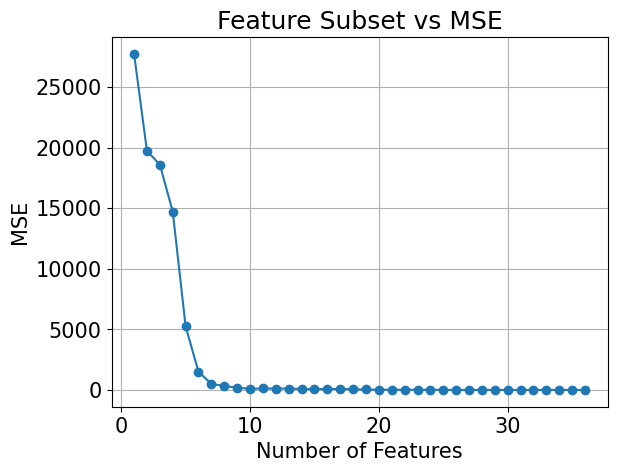

Best params for XGB: {'colsample_bylevel': 0.5, 'colsample_bytree': 0.7, 'max_depth': 3, 'n_estimators': 300}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3003
[LightGBM] [Info] Number of data points in the train set: 1205, number of used features: 26
[LightGBM] [Info] Start training from score 890.334440
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

def evaluate_feature_subsets(X, y, model, test_X, feature_step=1, max_features=40):
    model.fit(X, y)
    importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    scores = []
    feature_sets = []

    for i in range(feature_step, min(len(importance), max_features) + 1, feature_step):
        selected = importance[:i].index.tolist()
        model.fit(X[selected], y)
        preds = model.predict(X[selected])
        mse = mean_squared_error(y, preds)
        scores.append(mse)
        feature_sets.append(selected)

    best_idx = np.argmin(scores)
    best_features = feature_sets[best_idx]

    print(f"Best Feature Count: {len(best_features)}")
    print(f"Best Feature Subset: {best_features}")
    print(f"Best CV Score (MSE): {scores[best_idx]}")

    plt.plot(range(feature_step, feature_step * len(scores) + 1, feature_step), scores, marker='o')
    plt.title("Feature Subset vs MSE")
    plt.xlabel("Number of Features")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.show()

    return best_features

def train_with_gridsearch(X, y, model_type='xgb'):
    if model_type == 'xgb':
        model = xgb.XGBRegressor(random_state=42)
        param = {
            'max_depth': [3, 4],
            'n_estimators': [300, 400],
            'colsample_bytree': [0.5, 0.7],
            'colsample_bylevel': [0.5, 0.7],
        }
    elif model_type == 'lgbm':
        model = lgb.LGBMRegressor(random_state=42)
        param = {
            'n_estimators': [100, 150],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 4],
            'num_leaves': [20, 30]
        }

    grid = GridSearchCV(model, param, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X, y)
    print(f"Best params for {model_type.upper()}: {grid.best_params_}")
    return grid.best_estimator_

X_lunch = train[lunch_features]
y_lunch = train["menu2_people"]

testX_lunch = test[lunch_features]

# 1. Feature 중요도 기반 상위 특성 선택
xgb_base = xgb.XGBRegressor(random_state=42)
best_lunch_features = evaluate_feature_subsets(X_lunch, y_lunch, xgb_base, testX_lunch)

# 2. GridSearchCV 재학습
xgb_lunch_model = train_with_gridsearch(X_lunch[best_lunch_features], y_lunch, model_type='xgb')
lgbm_lunch_model = train_with_gridsearch(X_lunch[best_lunch_features], y_lunch, model_type='lgbm')

# 3. 예측 & 앙상블
y_pred_xgb_lunch = xgb_lunch_model.predict(testX_lunch[best_lunch_features])
y_pred_lgbm_lunch = lgbm_lunch_model.predict(testX_lunch[best_lunch_features])
ensemble_lunch = (y_pred_xgb_lunch + y_pred_lgbm_lunch) / 2

submit = pd.read_csv("/content/sample_submission.csv")
submit["중식계"] = ensemble_lunch

Best Feature Count: 26
Best Feature Subset: ['dinner_side', 'overtime', 'year', 'dow_4', 'week_num', 'attendance_rate', 'is_friday_before_weekend', 'dow_3', 'vacation', 'is_monday_after_weekend', 'month', 'business trip', 'rainfall', 'athome', 'day', 'max_temp', 'present', 'dow_2', 'dinner_banchan2', 'dinner_banchan3', 'dinner_banchan1', 'month_period_mid', 'total', 'dinner_gook', 'dinner_bab', 'min_temp']
Best CV Score (MSE): 7.48185552037205


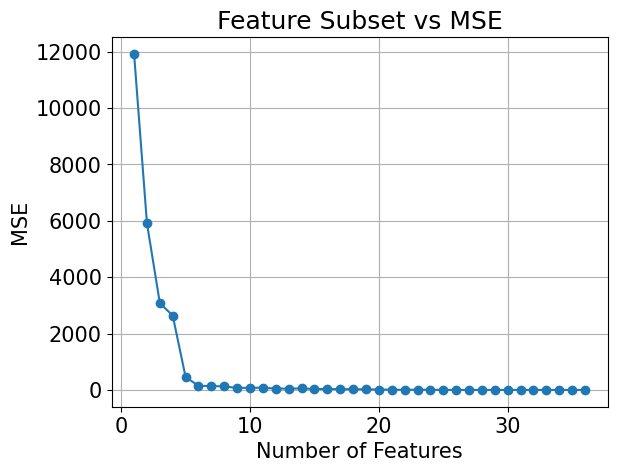

Best params for XGB: {'colsample_bylevel': 0.7, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 300}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3047
[LightGBM] [Info] Number of data points in the train set: 1205, number of used features: 26
[LightGBM] [Info] Start training from score 461.772614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [ ]:
X_dinner = train[dinner_features]
y_dinner = train["menu3_people"]
testX_dinner = test[dinner_features]

# 1. Feature 중요도 기반 상위 특성 선택
xgb_base_dinner = xgb.XGBRegressor(random_state=42)
best_dinner_features = evaluate_feature_subsets(X_dinner, y_dinner, xgb_base_dinner, testX_dinner)

# 2. GridSearchCV 재학습
xgb_dinner_model = train_with_gridsearch(X_dinner[best_dinner_features], y_dinner, model_type='xgb')
lgbm_dinner_model = train_with_gridsearch(X_dinner[best_dinner_features], y_dinner, model_type='lgbm')

# 3. 예측 & 앙상블
y_pred_xgb_dinner = xgb_dinner_model.predict(testX_dinner[best_dinner_features])
y_pred_lgbm_dinner = lgbm_dinner_model.predict(testX_dinner[best_dinner_features])
ensemble_dinner = (y_pred_xgb_dinner + y_pred_lgbm_dinner) / 2

# 결과 저장 (앞서 점심 예측한 ensemble_lunch와 함께 사용)
submit["석식계"] = ensemble_dinner

In [ ]:
submit.to_csv("submit_final.csv", index=False)
print(submit.head())

           일자          중식계         석식계
0  2021-01-27  1029.666528  373.365147
1  2021-01-28   965.275347  419.270501
2  2021-01-29   639.196113  282.917375
3  2021-02-01  1303.744054  546.304510
4  2021-02-02   994.707676  460.393590


#### feature importance 계산 - 결론

In [ ]:
# 점심
X_best = train[best_lunch_features]
y_best = train["menu2_people"]

best_model = xgb.XGBRegressor()
best_model.fit(X_best, y_best)

importance_df = pd.DataFrame({
    "Feature": X_best.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(importance_df)

                     Feature  Importance
0    is_monday_after_weekend    0.485617
1   is_friday_before_weekend    0.288207
5                   vacation    0.035716
7              business trip    0.019670
3                     athome    0.019375
2                      dow_4    0.018045
9                   overtime    0.013850
4            attendance_rate    0.013269
15                     month    0.011003
8                       year    0.010490
20                     total    0.010479
6                   week_num    0.010419
10                  rainfall    0.008285
11                     dow_2    0.007657
13                  min_temp    0.006054
14                   present    0.005732
12                lunch_side    0.005170
16                 lunch_bab    0.004876
17                  max_temp    0.004376
18                       day    0.003807
19            lunch_banchan1    0.003740
21            lunch_banchan2    0.003215
23                lunch_gook    0.003056
22              

In [ ]:
# 저녁
X_best = train[best_dinner_features]
y_best = train["menu2_people"]

best_model = xgb.XGBRegressor()
best_model.fit(X_best, y_best)

importance_df = pd.DataFrame({
    "Feature": X_best.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(importance_df)

                     Feature  Importance
9    is_monday_after_weekend    0.587386
6   is_friday_before_weekend    0.329842
8                   vacation    0.011377
13                    athome    0.011174
3                      dow_4    0.010633
11             business trip    0.006792
5            attendance_rate    0.005673
22                     total    0.004342
10                     month    0.003585
17                     dow_2    0.003576
4                   week_num    0.002931
12                  rainfall    0.002541
16                   present    0.002201
2                       year    0.002108
1                   overtime    0.002089
24                dinner_bab    0.002056
7                      dow_3    0.001661
15                  max_temp    0.001602
25                  min_temp    0.001405
20           dinner_banchan1    0.001246
14                       day    0.001230
18           dinner_banchan2    0.001168
19           dinner_banchan3    0.001096
23              